In [1]:
import numpy as np
import lbg_forecast.dust_priors as dpr
import lbg_forecast.sfh as sfh
import lbg_forecast.population_model as pop
import matplotlib.pyplot as plt

import lbg_forecast.priors_gp_dust as gpdp
dust_prior = gpdp.DustPrior('./')

Loading Models
Loading Complete


from duste.DustAttnCalc import DustAttnCalc
ngal = 100000

logM = np.random.uniform(8.74,11.30,ngal)
sfr = np.random.uniform(-5,2.5,ngal)
logZ = np.random.uniform(-1.70,0.18,ngal)
z=np.random.uniform(0.51,2.83,ngal)
i=np.random.uniform(0.09,0.97,ngal)
dobj = DustAttnCalc(sfr=sfr, logM=logM, logZ=logZ, z=z, i=i, bv=True, eff=False)
dac, dac1, n, tau, tau1, ne, taue, tau1e = dobj.calcDust(max_num_plot=0)

nagaraj_data = np.vstack((n, tau, tau1, ne, taue, tau1e, sfr))
np.save("dust_data/saved_nagaraj22samples.npy", nagaraj_data)

[0.3525552  0.3303906  0.2848055  0.30372622 0.28030095 0.27015153
 0.28458481 0.25453604 0.26708903 0.25719125 0.25777896 0.25228435
 0.24453756 0.23861239 0.2364851  0.23113633 0.22755392 0.22924914
 0.25684478 0.30193762 0.36305956 0.43615513 0.51675541 0.60554151
 0.7061579  0.80865258 0.91732408 1.05337339 1.09640069] [0.69503826 0.67649411 0.66633842 0.64850108 0.64170189 0.6293188
 0.62134659 0.60792224 0.60806177 0.65301791 0.78707208 0.94887988
 1.13461527 1.24198839]


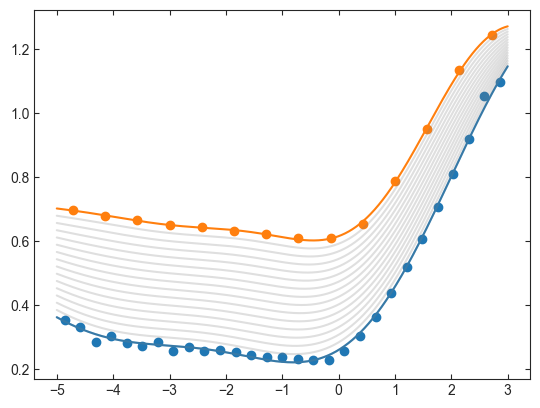

In [2]:
recent_sfrs, dust2, dust_index, dust1 = dust_prior.get_pop_cosmos_samples(1000000)
n, tau, tau1, ne, taue, tau1e, sfr = dust_prior.get_nagaraj22_samples()

d2xpop, d2ypop, d2yerrpop = gpdp.process_samples(recent_sfrs, dust2, -5, 3, 30)
plt.scatter(d2xpop, d2ypop)
plt.plot(dust_prior.dust2_grid, dust_prior.dust2_mean())

d2xnag, d2ynag, d2errnag = gpdp.process_samples(sfr, tau, -5, 3, 15)
plt.scatter(d2xnag, d2ynag)
plt.plot(dust_prior.dust2_grid, dust_prior.dust2_mean_nagaraj())

nplots = 15
for f in range(nplots):
    plt.plot(dust_prior.dust2_grid, dust_prior.interpolate_models(f/nplots), alpha=0.25, color='grey')

print(d2ypop, d2ynag)



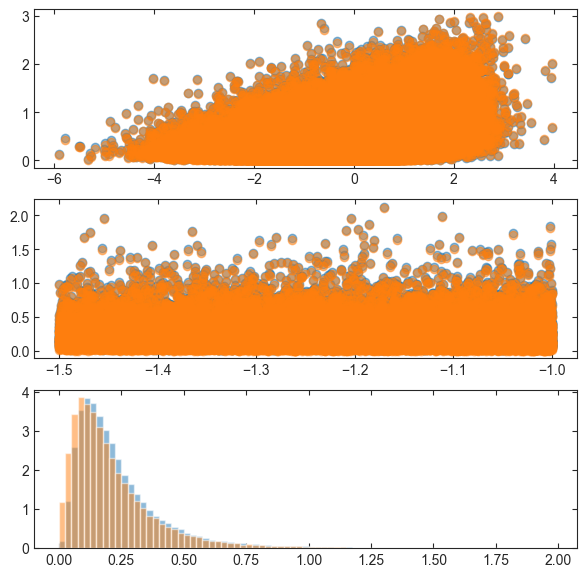

In [3]:
recent_sfrs, dust2, dust_index, dust1 = dust_prior.get_pop_cosmos_samples(1000000)

new_sfrs = recent_sfrs#np.random.uniform(-4, 3, 100000)
dust2_gp, dust_index_gp, dust1_gp = dust_prior.sample_dust_model(new_sfrs)

f, ax = plt.subplots(3, 1, figsize=(7, 7))
ax[0].scatter(recent_sfrs, dust2, alpha=0.5)
ax[0].scatter(new_sfrs, dust2_gp, alpha=0.5)

sfr_point = -1
inds0 = np.where((recent_sfrs<sfr_point)&(recent_sfrs>sfr_point-0.5))[0]
inds = np.where((new_sfrs<sfr_point)&(new_sfrs>sfr_point-0.5))[0]
ax[1].scatter(recent_sfrs[inds0], dust2[inds0], alpha=0.5)
ax[1].scatter(new_sfrs[inds], dust2_gp[inds], alpha=0.5)

bins = np.arange(0, 2, 0.025)
histogram = ax[2].hist(dust2[inds0], density=True, bins=bins, alpha=0.5)
histogram = ax[2].hist(dust2_gp[inds], density=True, bins=bins, alpha=0.5)

Loading Models
Loading Complete


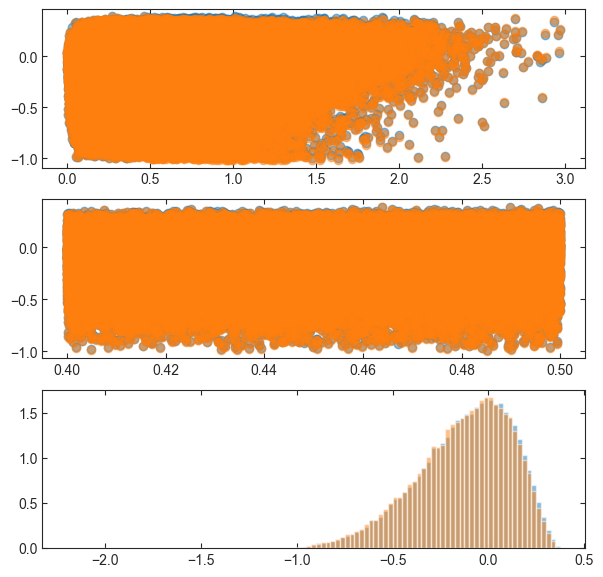

In [4]:
recent_sfrs, dust2, dust_index, dust1 = dust_prior.get_pop_cosmos_samples(1000000)

dust_prior = gpdp.DustPrior('./')
#dust2_gp, dust_index_gp, dust1_gp = dust_prior.sample_dust_model(recent_sfrs)
dust2_gp = dust2#np.random.uniform(0, 4, 500000)
dust_index_gp = dust_prior.sample_dust_index(dust2_gp)

f, ax = plt.subplots(3, 1, figsize=(7, 7))
ax[0].scatter(dust2, dust_index, alpha=0.5)
ax[0].scatter(dust2_gp, dust_index_gp, alpha=0.5)

dust2_point = 0.5
inds0 = np.where((dust2<dust2_point)&(dust2>dust2_point-0.1))[0]
inds = np.where((dust2_gp<dust2_point)&(dust2_gp>dust2_point-0.1))[0]

ax[1].scatter(dust2[inds0], dust_index[inds0], alpha=0.5)
ax[1].scatter(dust2_gp[inds], dust_index_gp[inds], alpha=0.5)

bins = np.arange(-2.2, 0.4, 0.025)
histogram = ax[2].hist(dust_index[inds0], density=True, bins=bins, alpha=0.5)
histogram = ax[2].hist(dust_index_gp[inds], density=True, bins=bins, alpha=0.5)

Loading Models
Loading Complete


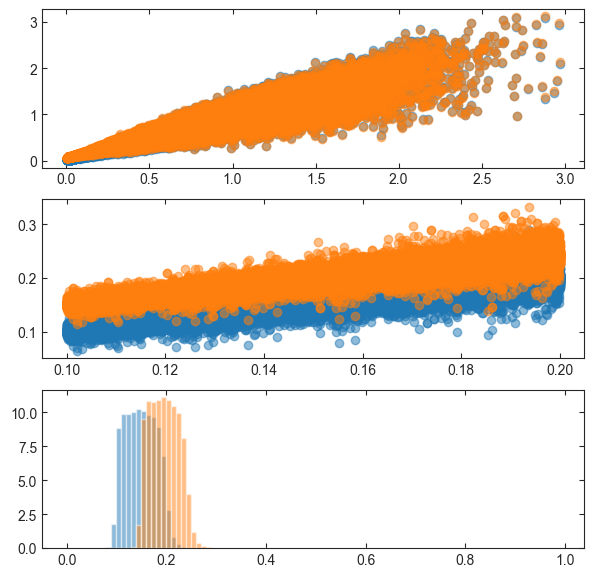

In [5]:
recent_sfrs, dust2, dust_index, dust1 = dust_prior.get_pop_cosmos_samples(1000000)

dust_prior = gpdp.DustPrior('./')
#dust2_gp, dust_index_gp, dust1_gp = dust_prior.sample_dust_model(recent_sfrs)
dust2_gp = dust2#np.random.uniform(0, 4, 500000)
dust1_gp = dust_prior.sample_dust1(dust2_gp)

f, ax = plt.subplots(3, 1, figsize=(7, 7))
ax[0].scatter(dust2, dust1, alpha=0.5)
ax[0].scatter(dust2_gp, dust1_gp, alpha=0.5)

dust2_point = 0.2
inds0 = np.where((dust2<dust2_point)&(dust2>dust2_point-0.1))[0]
inds = np.where((dust2_gp<dust2_point)&(dust2_gp>dust2_point-0.1))[0]

ax[1].scatter(dust2[inds0], dust1[inds0], alpha=0.5)
ax[1].scatter(dust2_gp[inds], dust1_gp[inds], alpha=0.5)

bins = np.arange(0.0, 1.0, 0.01)
histogram = ax[2].hist(dust1[inds0], density=True, bins=bins, alpha=0.5)
histogram = ax[2].hist(dust1_gp[inds], density=True, bins=bins, alpha=0.5)

In [6]:
run = 'test'
spsp = np.load("sps_parameter_samples/sps_"+run+".npy")
photometry = np.load("photo_samples/photo_"+run+".npy")
nzs = np.load("nz_samples/nz_"+run+".npy", allow_pickle=True)

print(spsp.shape, nzs)

(8, 200000, 17) [[array([0.05669445, 0.05669445, 2.70629826, 2.7948289 , 2.54573396,
         2.90972802, 2.60586525, 2.73744482, 3.05846418, 2.81851608,
         3.02455838, 2.66065149, 2.66065149, 2.17074421, 2.90577112,
         0.10903645, 3.22895875, 3.19104276, 2.58884866, 2.58884866,
         2.74107353, 3.39302319, 2.55958354, 2.05653926, 3.04428486,
         2.33555244, 2.44176171, 2.86433024, 3.11181694, 3.30908431,
         2.4460235 , 3.24915606, 2.7963103 , 2.91310451, 2.68609392,
         2.82270592, 2.70145598, 3.04998297, 2.52676179, 2.2718113 ,
         0.10437788, 2.59864354, 2.989835  , 2.60391076, 2.15382772,
         2.99652599, 0.55153702, 2.99652599, 0.10817672, 0.78541182,
         2.19640512, 0.04219589, 3.16406276, 3.16641317, 3.05196462,
         3.04836926, 2.49774671, 3.07941479, 2.95738337, 3.34166033,
         2.78860156, 3.60202165, 2.63684168, 2.30436216, 2.66981597,
         0.09470459, 3.10098137, 2.63939541, 0.08897198, 2.51444705,
         2.8394333

(8, 200000, 17)


(-5.0, 3.0)

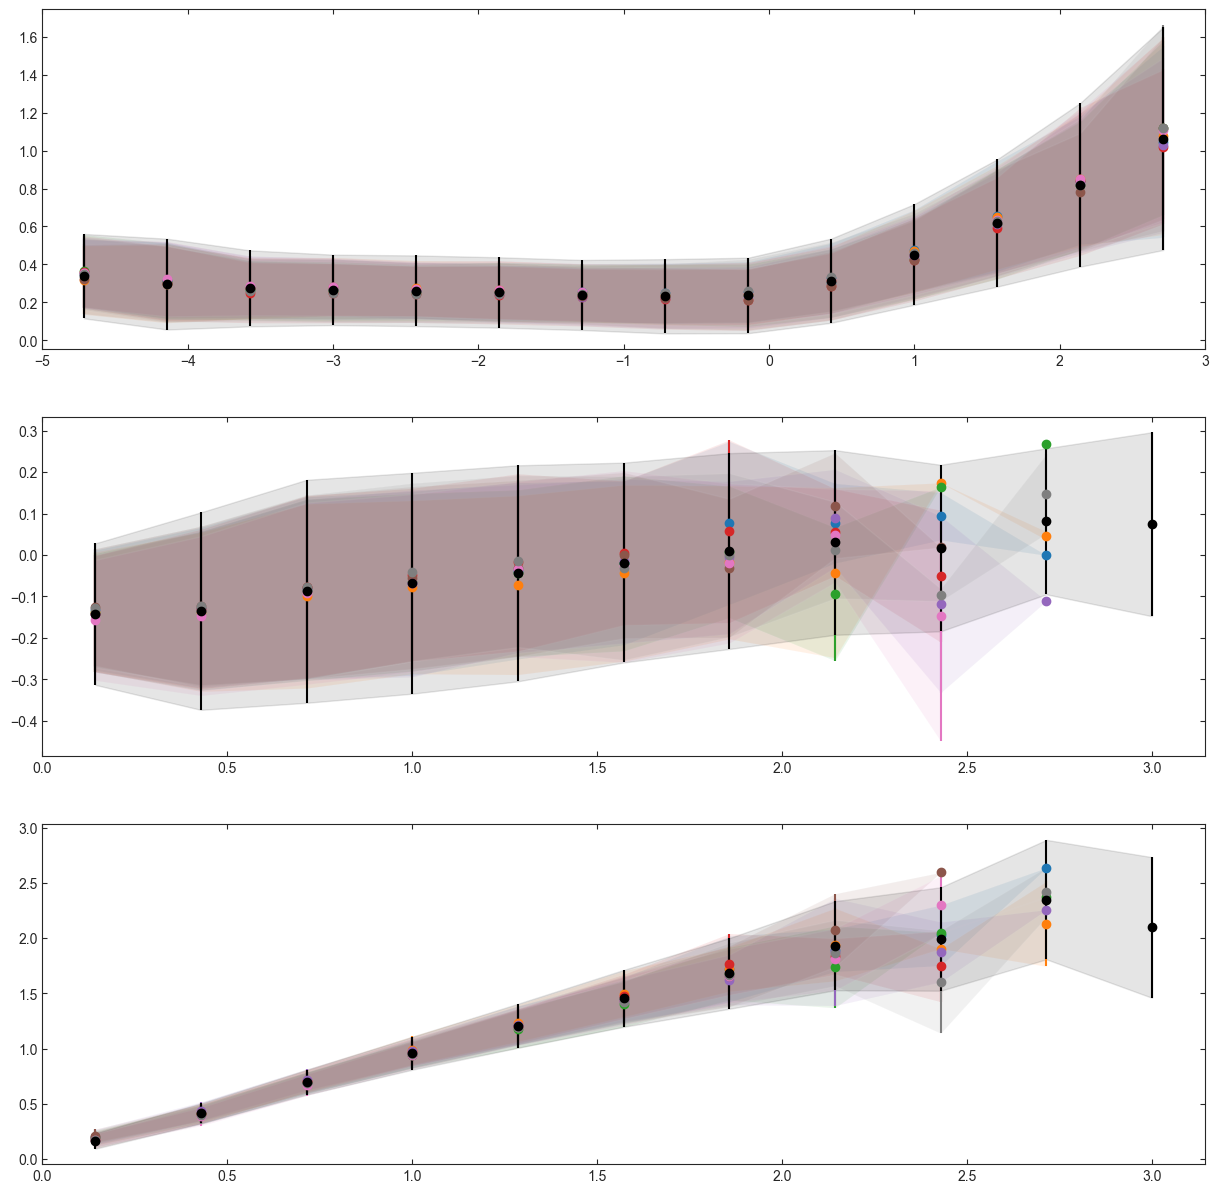

In [7]:
print(spsp.shape)
f, ax = plt.subplots(3, 1, figsize=(15, 15))
recent_sfrs_pop, dust2_pop, dust_index_pop, dust1_pop = dust_prior.get_pop_cosmos_samples(1000000)

for i in range(spsp.shape[0]):

    sps_real = spsp[i]
    redshifts = sps_real[:, 0]
    logmasses = sps_real[:, -1]
    logsfrratios = sps_real[:, 10:-1]
    dust = sps_real[:, 2:5]
    dust1 = dust[:, 0]
    dust_index = dust[:, 2]
    dust2 = dust[:, 1]
    recent_sfrs = np.log10(sfh.calculate_recent_sfr(redshifts, logmasses, logsfrratios))

    d2x, d2y, d2yerr = gpdp.process_samples(recent_sfrs, dust2, -5, 3)
    ax[0].errorbar(d2x, d2y, d2yerr, fmt='o')
    ax[0].fill_between(d2x, d2y-d2yerr, d2y+d2yerr, alpha=0.1)

    dix, diy, diyerr = gpdp.process_samples(dust2, dust_index, 0, 4)
    ax[1].errorbar(dix, diy, diyerr, fmt='o')
    ax[1].fill_between(dix, diy-diyerr, diy+diyerr, alpha=0.1)

    d1x, d1y, d1yerr = gpdp.process_samples(dust2, dust1, 0, 4)
    ax[2].errorbar(d1x, d1y, d1yerr, fmt='o')
    ax[2].fill_between(d1x, d1y-d1yerr, d1y+d1yerr, alpha=0.1)

d2x, d2y, d2yerr = gpdp.process_samples(recent_sfrs_pop, dust2_pop, -5, 3)
ax[0].errorbar(d2x, d2y, d2yerr, fmt='ko')
ax[0].fill_between(d2x, d2y-d2yerr, d2y+d2yerr, alpha=0.1, color='k')

dix, diy, diyerr = gpdp.process_samples(dust2_pop, dust_index_pop, 0, 4)
ax[1].errorbar(dix, diy, diyerr, fmt='ko')
ax[1].fill_between(dix, diy-diyerr, diy+diyerr, alpha=0.1, color='k')

d1x, d1y, d1yerr = gpdp.process_samples(dust2_pop, dust1_pop, 0, 4)
ax[2].errorbar(d1x, d1y, d1yerr, fmt='ko')
ax[2].fill_between(d1x, d1y-d1yerr, d1y+d1yerr, alpha=0.1, color='k')

ax[0].set_xlim(-5, 3)


(8, 200000, 17)


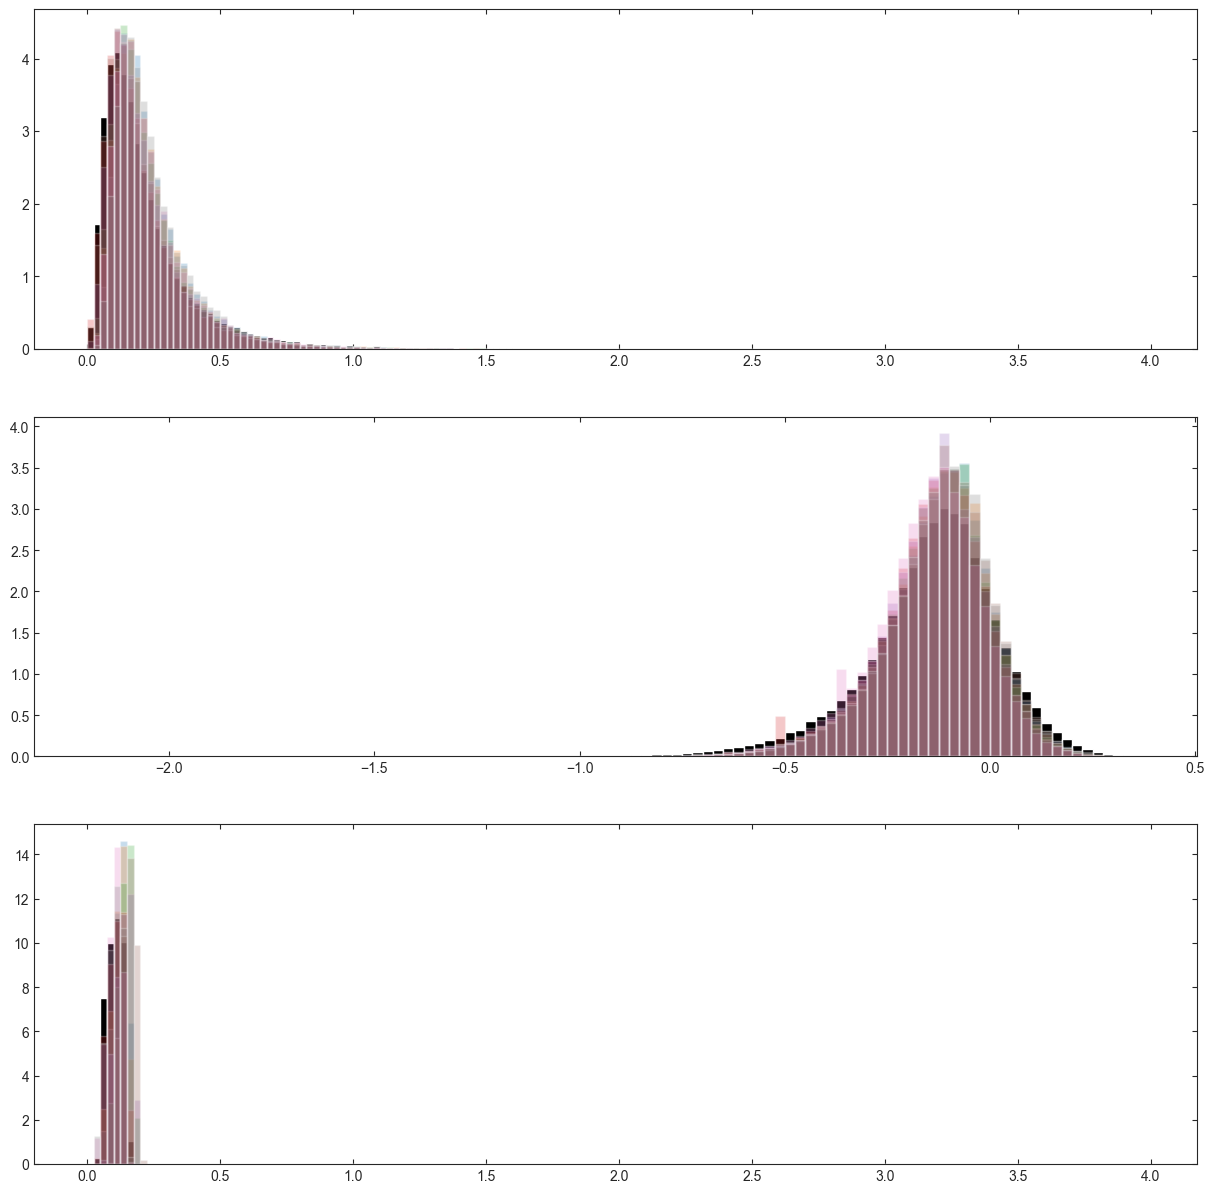

In [8]:
print(spsp.shape)
f, ax = plt.subplots(3, 1, figsize=(15, 15))
recent_sfrs_pop, dust2_pop, dust_index_pop, dust1_pop = dust_prior.get_pop_cosmos_samples(1000000)

sfr_point = 0
d2_point = 1.0
d2_point2 = 0.15
dsfr = 0.5
dd2 = 0.1
dd22 = 0.1
d2_bins = np.arange(0.0, 4.0, 0.025)
dibins = np.arange(-2.2, 0.4, 0.025)

for i in range(spsp.shape[0]):

    sps_real = spsp[i]
    redshifts = sps_real[:, 0]
    logmasses = sps_real[:, -1]
    logsfrratios = sps_real[:, 10:-1]
    dust = sps_real[:, 2:5]
    dust1 = dust[:, 0]
    dust_index = dust[:, 2]
    dust2 = dust[:, 1]
    recent_sfrs = np.log10(sfh.calculate_recent_sfr(redshifts, logmasses, logsfrratios))
    
    inds = np.where((recent_sfrs<sfr_point)&(recent_sfrs>sfr_point-dsfr))[0]
    histogram = ax[0].hist(dust2[inds], density=True, bins=d2_bins, alpha=0.25)

    inds = np.where((dust2<dust2_point)&(dust2>dust2_point-dd2))[0]
    histogram = ax[1].hist(dust_index[inds], density=True, bins=dibins, alpha=0.25)

    inds = np.where((dust2<d2_point2)&(dust2>d2_point2-dd22))[0]
    histogram = ax[2].hist(dust1[inds], density=True, bins=d2_bins, alpha=0.25)

inds0 = np.where((recent_sfrs_pop<sfr_point)&(recent_sfrs_pop>sfr_point-dsfr))[0]
histogram = ax[0].hist(dust2_pop[inds0], density=True, bins=d2_bins, color='k', zorder=-1)

inds0 = np.where((dust2_pop<dust2_point)&(dust2_pop>dust2_point-dd2))[0]
histogram = ax[1].hist(dust_index_pop[inds0], density=True, bins=dibins, color='k', zorder=-1)

inds0 = np.where((dust2_pop<d2_point2)&(dust2_pop>d2_point2-dd22))[0]
histogram = ax[2].hist(dust1_pop[inds0], density=True, bins=d2_bins, color='k', zorder=-1)

In [9]:
#np.save("dust_data/popcosmos_recentsfrs.npy", dust_prior.recent_sfrs)
#nagaraj22 = np.array([dust_prior.n, dust_prior.tau, dust_prior.tau1, dust_prior.ne, dust_prior.taue, dust_prior.tau1e, dust_prior.sfr])
#np.save("dust_data/saved_nagaraj22samples.npy", nagaraj22)